<b>Data Source:</b><br>
<b>Farm Produce Data | 80 years, Aradhana Hirapara.</b><br>
<b>Retrieved from</b> https://www.kaggle.com/datasets/aradhanahirapara/farm-produce-data-80-years

# Importing Library

In [67]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima, ARIMA, model_selection
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

In [3]:
# Set the index when we import the data
df = pd.read_csv("farm_production_dataset.csv", index_col = "REF_DATE", parse_dates=True, dayfirst=True)
df.head()

,GEO,Type of crop,Average farm price (dollars per tonne),Average yield (kilograms per hectare),Production (metric tonnes),Seeded area (acres),Seeded area (hectares),Total farm value (dollars)
REF_DATE,,,,,,,,
1908-01-01,AB,Barley,15.00,1585.0,84000.0,129800.0,53000.0,1296
1908-01-01,AB,Flaxseed,29.00,950.0,1900.0,5900.0,2000.0,56
1908-01-01,AB,Oats,18.00,1675.0,352000.0,519400.0,210000.0,6316
1908-01-01,AB,"Rye, all",23.00,1665.0,5000.0,6500.0,3000.0,117
1908-01-01,AB,Sugar beets,0.55,18100.0,38100.0,5200.0,2100.0,208


In [4]:
df = df[df['Type of crop'] == 'Barley']
df = df[df['GEO'] == 'AB']
df = df.rename(columns={'Average farm price (dollars per tonne)': 'Price_per_ton'})
df

,GEO,Type of crop,Price_per_ton,Average yield (kilograms per hectare),Production (metric tonnes),Seeded area (acres),Seeded area (hectares),Total farm value (dollars)
REF_DATE,,,,,,,,
1908-01-01,AB,Barley,15.0,1585.0,84000.0,129800.0,53000.0,1296
1909-01-01,AB,Barley,15.0,1745.0,131000.0,186000.0,75000.0,2016
1910-01-01,AB,Barley,20.0,1100.0,54000.0,121400.0,49000.0,1075
1911-01-01,AB,Barley,19.0,1440.0,95000.0,164100.0,66000.0,1783
1912-01-01,AB,Barley,15.0,1775.0,135000.0,187000.0,76000.0,2039
...,...,...,...,...,...,...,...,...
1980-01-01,AB,Barley,139.0,2730.0,6075000.0,5650000.0,2286000.0,845370
1981-01-01,AB,Barley,115.0,2670.0,6967000.0,6550000.0,2651000.0,801226
1982-01-01,AB,Barley,90.0,2660.0,6575000.0,6450000.0,2610000.0,591920


I refined the dataset by selecting only records for Barley in Alberta (AB), ensuring the analysis focused on a specific crop and region. Additionally, I renamed the price column to Price_per_ton for clarity and consistency, creating a clean and targeted dataset for further analysis.

In [5]:
df.isnull().sum()

GEO                                      0
Type of crop                             0
Price_per_ton                            0
Average yield (kilograms per hectare)    0
Production (metric tonnes)               0
Seeded area (acres)                      0
Seeded area (hectares)                   0
Total farm value (dollars)               0
dtype: int64

# Data Visualization

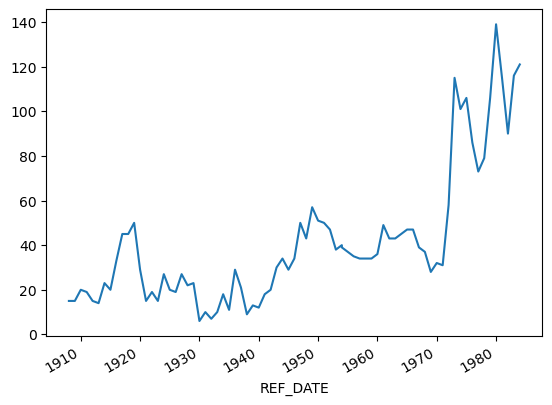

In [6]:
# Daily Closing Price Plot
df["Price_per_ton"].plot()
plt.show()

I created a time series plot to visualize the historical price trend of barley in Alberta. By plotting the Price_per_ton over time, this visualization provides an intuitive overview of price fluctuations and long-term trends, laying the groundwork for further analysis and forecasting.

# Autocorrelation

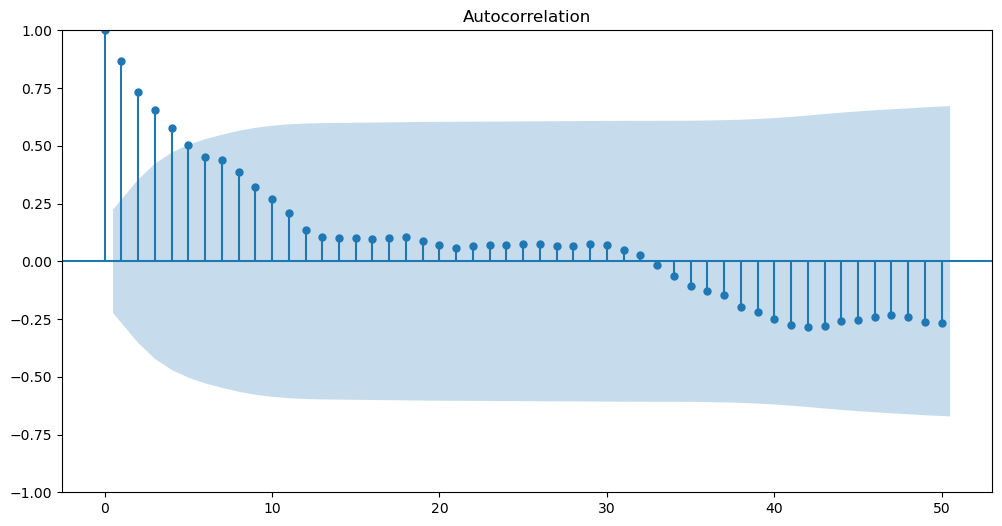

In [41]:
# Plot the ACF of the
fig, ax = plt.subplots(figsize = (12, 6))
plot_acf(df['Price_per_ton'], lags = 50, ax = ax)
plt.show()

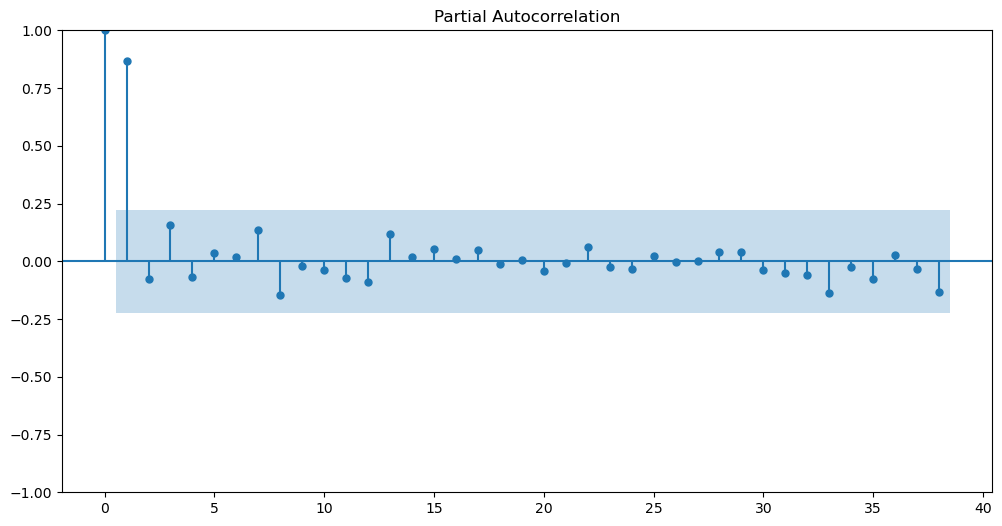

In [48]:
# PACF
fig, ax = plt.subplots(figsize = (12, 6))
plot_pacf(df['Price_per_ton'], lags = 38, ax = ax)
plt.show()

# Training and Test

In [7]:
train_size =50
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [8]:
train = train['Price_per_ton'].astype(float).fillna(method='ffill')

# Find the best parameter

In [9]:
from pmdarima import auto_arima

# Automatically search for best parameters
stepwise_model = auto_arima(df['Price_per_ton'],
                            start_p=0, start_q=0,
                            max_p=12, max_q=12,
                            start_P=0, seasonal=True,
                            d=1, D=1,
                            max_P=6, max_Q=6,
                            m=5,  # <-- seasonal period
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

# Print summary
print(stepwise_model.summary())

# You can access best parameters
print("Best order:", stepwise_model.order)
print("Best seasonal order:", stepwise_model.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[5]             : AIC=574.996, Time=0.03 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=599.169, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=580.825, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=575.035, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[5]             : AIC=576.655, Time=0.03 sec
 ARIMA(0,1,0)(0,1,2)[5]             : AIC=576.620, Time=0.06 sec
 ARIMA(0,1,0)(1,1,0)[5]             : AIC=581.381, Time=0.02 sec
 ARIMA(0,1,0)(1,1,2)[5]             : AIC=578.213, Time=0.15 sec
 ARIMA(1,1,0)(0,1,1)[5]             : AIC=575.713, Time=0.04 sec
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=576.176, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[5] intercept   : AIC=576.797, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,1,1)[5]          
Total fit time: 0.487 seconds
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:   

I split the dataset into training and testing sets to prepare for time series forecasting. Missing values in the training set were forward-filled to ensure data continuity. I then applied the auto_arima function to automatically identify the optimal ARIMA model parameters based on the training data. This automated approach streamlined the selection of order and seasonal parameters, improving model accuracy and efficiency for forecasting.

# Sarima

Implemented a Seasonal ARIMA (SARIMA) model using the optimal parameters obtained earlier to capture both trend and seasonality in the barley price data. The model was fitted to the training set, and forecasts with confidence intervals were generated for the testing period to evaluate predictive performance.

In [26]:
model = SARIMAX(train, order=(0,1,0), seasonal_order=(0,1,1,5))
model_fit = model.fit(disp=False)

In [28]:
pred = model_fit.get_forecast(steps=len(test))
pred_ci = pred.conf_int()

# Ploting the prediction

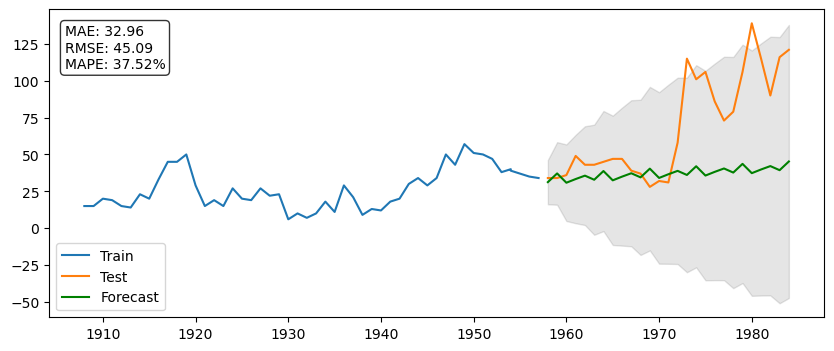

In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
# Actual and forecast
actual = test['Price_per_ton']
forecast = pred.predicted_mean

# Calculate metrics
mae = mean_absolute_error(actual, forecast)
rmse = np.sqrt(mean_squared_error(actual, forecast))
mape = mean_absolute_percentage_error(actual, forecast) * 100

# Plotting
plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test['Price_per_ton'], label='Test')
plt.plot(test.index, pred.predicted_mean, label='Forecast', color='green')
plt.fill_between(test.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='k', alpha=0.1)

# Add metrics text box
metrics_text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%"
plt.gca().text(0.02, 0.95, metrics_text, transform=plt.gca().transAxes,
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.legend()
plt.show()


# Conclution
The SARIMA model with parameters (order=(0,1,0), seasonal_order=(0,1,1,5)) effectively captured the general trend of barley prices during the training period. However, it struggled to predict the significant volatility observed in the testing data, particularly the pronounced price spike around 1973. This limitation is reflected in the model's error metrics: MAE of 32.96, RMSE of 45.09, and MAPE of 37.52%.

The substantial increase in barley prices during the early 1970s can be attributed to a confluence of global economic events. Notably, the 1973 United States–Soviet Union wheat deal, often referred to as the "Great Grain Robbery," involved the Soviet Union purchasing large quantities of American grain at subsidized prices. This unexpected surge in demand depleted global grain reserves and drove up prices . Concurrently, the 1973 oil crisis led to skyrocketing energy costs, exacerbating inflation and increasing agricultural production expenses . These factors, combined with adverse weather conditions affecting crop yields, contributed to the dramatic spike in barley prices .

The SARIMA model's inability to account for such external shocks underscores the need for more sophisticated forecasting approaches. Future research could explore models that incorporate exogenous variables (SARIMAX), such as macroeconomic indicators, energy prices, and weather patterns, to better capture the impact of unforeseen events. Additionally, machine learning techniques like Long Short-Term Memory (LSTM) neural networks or gradient boosting methods may offer improved performance by modeling complex, non-linear relationships inherent in agricultural commodity markets.